# TSFEL and RF Classifier

## Data Loading

In [1]:
import os
import pandas as pd

In [2]:
master_folder = "../EMG_data_for_gestures-master"
cleaned_data_by_subject = {}

In [3]:
# Loop through each subject's folder
for subject_folder in sorted(os.listdir(master_folder)):
    subject_path = os.path.join(master_folder, subject_folder)

    if os.path.isdir(subject_path):  # Check if it's a directory
        subject_number = int(subject_folder)  # Convert subject folder name to an integer
        
        trials = []
        
        for file_name in sorted(os.listdir(subject_path)):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subject_path, file_name)
                
                # Load the .txt file with proper handling for mixed types and whitespace delimiter
                df = pd.read_csv(file_path, delim_whitespace=True, dtype=str)  # Load as strings to avoid dtype issues

                # Drop 'time' column
                df.drop('time', inplace=True, axis=1)
                
                # Drop rows where 'class' column has NaNs or non-numeric values
                df = df[df["class"].notna() & df["class"].str.isnumeric()]
                
                # Convert 'class' column to integer
                df["class"] = df["class"].astype(int)
                
                # Keep only relevant classes (1 to 6) and drop others
                df = df[df["class"].isin([1, 2, 3, 4, 5, 6])]
                
                # Append the cleaned trial data to the list
                trials.append(df)
        
        # Concatenate trials for the current subject
        subject_data = pd.concat(trials, axis=0).reset_index(drop=True)
        
        # Store the cleaned data for the subject
        cleaned_data_by_subject[subject_number] = subject_data

print(f"Loaded and cleaned data for {len(cleaned_data_by_subject)} subjects.")

Loaded and cleaned data for 36 subjects.


In [4]:
segmented_data_by_subject = {}

# Loop through each subject's cleaned data
for subject_number, subject_data in cleaned_data_by_subject.items():
    segmented_trials = []  # Store segmented data for all trials of this subject

    # Sort trials by 'trial' column if applicable
    if 'trial' in subject_data.columns:
        trials = subject_data.groupby('trial')
    else:
        trials = [(None, subject_data)]  # Single trial case

    # Process each trial separately
    for trial_id, trial_data in trials:
        trial_segments = []  # Store all segments for this trial

        # Identify gesture segments by detecting label changes
        current_label = trial_data.iloc[0]['class']  # Start with the first label
        start_index = 0  # Index for the beginning of the segment

        for i in range(1, len(trial_data)):
            if trial_data.iloc[i]['class'] != current_label:
                # Extract the segment for the current label
                segment = trial_data.iloc[start_index:i]
                trial_segments.append(segment)

                # Update the current label and start index
                current_label = trial_data.iloc[i]['class']
                start_index = i

        # Capture the last segment
        segment = trial_data.iloc[start_index:]
        trial_segments.append(segment)

        # Add the segmented data for this trial
        segmented_trials.extend(trial_segments)

    # Store segmented data for the subject
    segmented_data_by_subject[subject_number] = segmented_trials

print(f"Segmented data for {len(segmented_data_by_subject)} subjects.")

Segmented data for 36 subjects.


## Sliding Window

In [5]:
import numpy as np

In [6]:
def extract_sliding_windows(segmented_data, window_size, stride):
    """
    Extracts sliding windows from segmented data.

    Args:
        segmented_data (dict): Segmented data by subject.
        window_size (int): Number of samples in each window.
        stride (int): Step size between consecutive windows.

    Returns:
        list: A list of tuples where each tuple is (window_data, window_label).
    """
    sliding_windows = []

    for subject, trials in segmented_data.items():
        # print(f"Processing Subject {subject}...")
        
        for segment in trials:
            segment_label = segment['class'].iloc[0]  # The class label for the entire segment
            segment_data = segment.drop(columns=['class']).values  # Drop the label column
            
            # Generate windows from this segment
            for start_idx in range(0, len(segment_data) - window_size + 1, stride):
                window = segment_data[start_idx:start_idx + window_size]
                sliding_windows.append((window, segment_label))
    
    print(f"Extracted {len(sliding_windows)} windows.")
    return sliding_windows

In [7]:
# Parameters for sliding windows
window_size = 500  # e.g., 100 samples per window
stride = 100        # e.g., 50-sample step size

# Extract sliding windows from segmented data
sliding_windows = extract_sliding_windows(segmented_data_by_subject, window_size, stride)

# Inspect the number of windows
print(f"Total sliding windows: {len(sliding_windows)}")

# Example: Shape of one window and its label
example_window, example_label = sliding_windows[0]
print(f"Window shape: {example_window.shape}, Label: {example_label}")

Extracted 11105 windows.
Total sliding windows: 11105
Window shape: (500, 8), Label: 1


Selected Window Index: 0
Window Shape: (500, 8) (Rows: Timepoints, Columns: Channels)
Class Label: 1


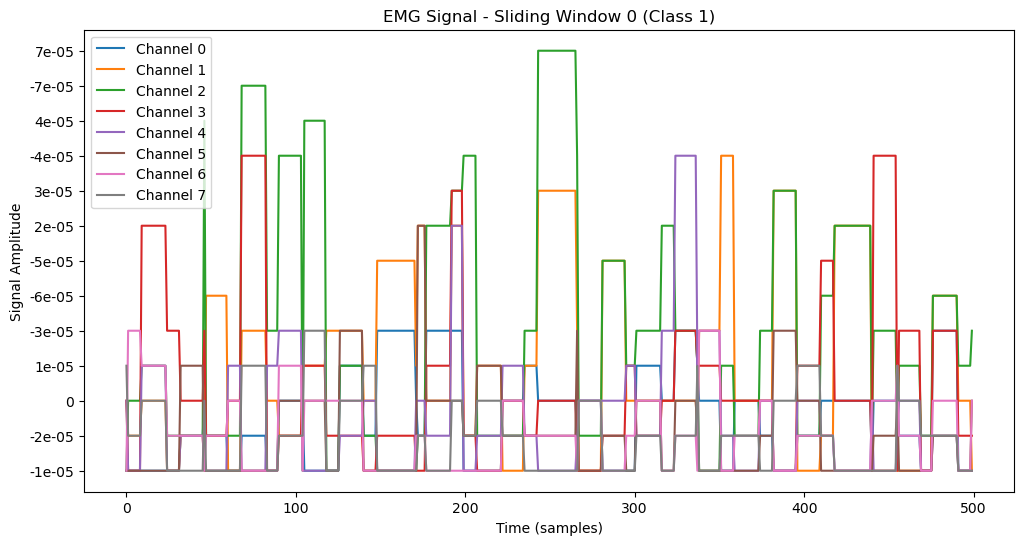

In [8]:
import matplotlib.pyplot as plt

# Select a random window to inspect
window_idx = 0  # Change this to inspect different windows
window_data, window_label = sliding_windows[window_idx]

# Convert to DataFrame for better visualization
window_df = pd.DataFrame(window_data, columns=[f'channel_{i}' for i in range(window_data.shape[1])])

# Print window metadata
print(f"Selected Window Index: {window_idx}")
print(f"Window Shape: {window_df.shape} (Rows: Timepoints, Columns: Channels)")
print(f"Class Label: {window_label}")

# Plot each channel's signal
plt.figure(figsize=(12, 6))
for i in range(window_df.shape[1]):  # Loop through channels
    plt.plot(window_df.index, window_df.iloc[:, i], label=f'Channel {i}')

plt.xlabel("Time (samples)")
plt.ylabel("Signal Amplitude")
plt.title(f"EMG Signal - Sliding Window {window_idx} (Class {window_label})")
plt.legend()
plt.show()

## TSFEL Feature Extraction

In [9]:
import tsfel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# Load default TSFEL feature configuration
cfg = tsfel.get_features_by_domain()  # Extracts all features by default

In [11]:
# Initialize feature and label lists
X_features = []
labels = []

# Extract TSFEL features
for window_data, window_label in sliding_windows:
    window_df = pd.DataFrame(window_data, columns=[f'channel_{i}' for i in range(window_data.shape[1])])

    # Extract features
    features_df = tsfel.time_series_features_extractor(cfg, window_df, fs=1000, verbose=0)

    # Store features and labels
    X_features.append(features_df.values.flatten())  # Keep original order
    labels.append(window_label)

# Convert to NumPy arrays
X = np.array(X_features)
y = np.array(labels)

# Convert back to DataFrame with correct column names
feature_names = features_df.columns.tolist()  # Get the TSFEL feature names
X_df = pd.DataFrame(X, columns=feature_names)  # Keep the correct names

print(f"Feature matrix shape: {X_df.shape}, Labels shape: {y.shape}")

Feature matrix shape: (11105, 1248), Labels shape: (11105,)


In [12]:
print(X_df.head())  # Check the first few rows
print(X_df.columns.tolist())  # Check correct column names

   channel_0_Absolute energy  channel_0_Area under the curve  \
0               1.209000e-07                        0.000006   
1               1.126000e-07                        0.000005   
2               9.580000e-08                        0.000005   
3               1.258000e-07                        0.000006   
4               1.266000e-07                        0.000006   

   channel_0_Autocorrelation  channel_0_Average power  channel_0_Centroid  \
0                       11.0             2.422846e-07            0.240612   
1                       11.0             2.256513e-07            0.211327   
2                        9.0             1.919840e-07            0.307882   
3                        9.0             2.521042e-07            0.287876   
4                       10.0             2.537074e-07            0.271137   

   channel_0_ECDF Percentile Count_0  channel_0_ECDF Percentile Count_1  \
0                          100.00000                          400.00000   
1 

## Random Forest with EVERYTHING

In [13]:
from sklearn.model_selection import train_test_split

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 8884, Testing samples: 2221


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the classifier
rf_classifier.fit(X_train, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


Random Forest Accuracy: 0.9860
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       370
           2       0.99      0.99      0.99       357
           3       0.98      0.99      0.99       369
           4       0.96      0.98      0.97       374
           5       0.99      0.97      0.98       374
           6       0.99      0.98      0.99       377

    accuracy                           0.99      2221
   macro avg       0.99      0.99      0.99      2221
weighted avg       0.99      0.99      0.99      2221



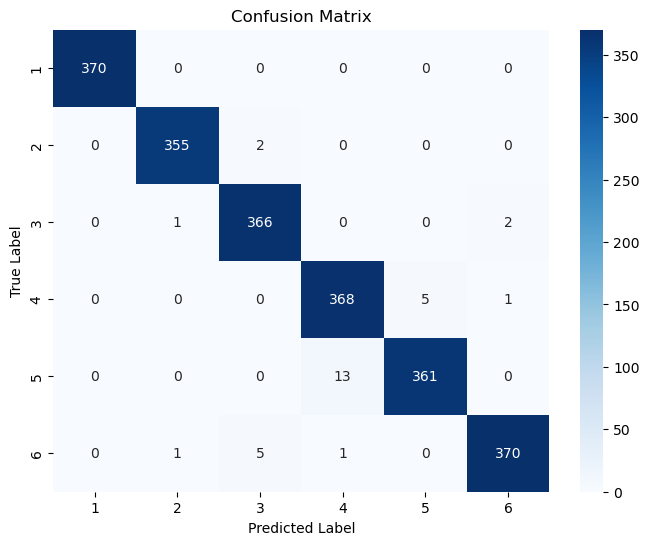

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute and print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Trees: 10 | Train Accuracy: 0.9988 | Test Accuracy: 0.9770
Trees: 50 | Train Accuracy: 1.0000 | Test Accuracy: 0.9856
Trees: 100 | Train Accuracy: 1.0000 | Test Accuracy: 0.9860
Trees: 200 | Train Accuracy: 1.0000 | Test Accuracy: 0.9878
Trees: 300 | Train Accuracy: 1.0000 | Test Accuracy: 0.9892
Trees: 500 | Train Accuracy: 1.0000 | Test Accuracy: 0.9901


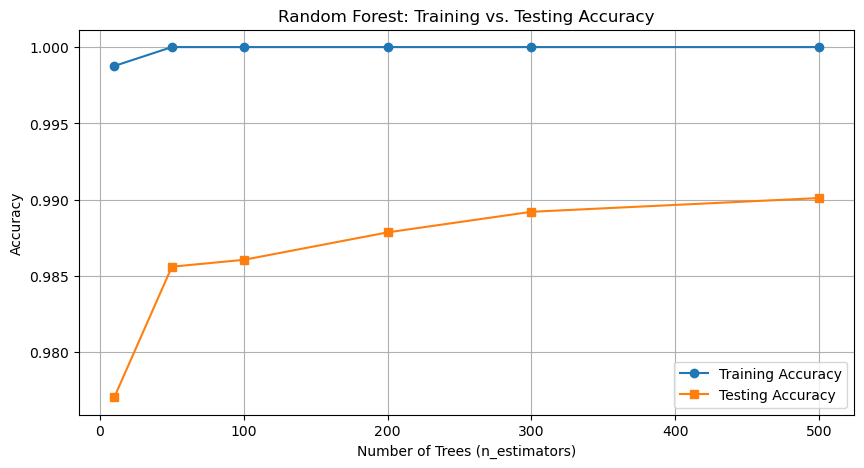

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define different numbers of trees to test
tree_counts = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []

# Train and evaluate models with different tree counts
for n_trees in tree_counts:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Compute accuracy
    train_acc = accuracy_score(y_train, rf.predict(X_train))  # Training accuracy
    test_acc = accuracy_score(y_test, rf.predict(X_test))  # Testing accuracy

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Trees: {n_trees} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

# Plot training vs. testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(tree_counts, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(tree_counts, test_accuracies, label="Testing Accuracy", marker="s")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest: Training vs. Testing Accuracy")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame mapping feature names to importance values
importances_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": feature_importances
})

# Sort features by importance (descending order)
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Display the top 10 most important features
print(importances_df.head(10))

                               Feature  Importance
1165       channel_7_Spectral distance    0.015782
955                  channel_6_Entropy    0.013442
1052       channel_6_Sum absolute diff    0.009879
1208       channel_7_Sum absolute diff    0.009504
1227  channel_7_Wavelet energy_83.33Hz    0.009256
535         channel_3_Root mean square    0.008854
1009       channel_6_Spectral distance    0.008620
1223  channel_7_Wavelet energy_35.71Hz    0.008259
1207      channel_7_Standard deviation    0.008238
752   channel_4_Wavelet energy_250.0Hz    0.008157


In [26]:
# Extract the general feature name (remove "channel_X_" prefix)
import re

# Function to remove the channel prefix from feature names
def extract_feature_type(feature_name):
    return re.sub(r'channel_\d+_', '', feature_name)  # Remove "channel_X_"

# Apply the function to extract general feature types
importances_df["General Feature"] = importances_df["Feature"].apply(extract_feature_type)

# Aggregate importance scores by feature type
general_importance_df = importances_df.groupby("General Feature")["Importance"].sum().reset_index()

# Sort by overall importance
general_importance_df = general_importance_df.sort_values(by="Importance", ascending=False)

# Display the top 210 most important feature types
print(general_importance_df.head(10))

                        General Feature  Importance
73                    Spectral distance    0.041213
67                     Root mean square    0.038689
115                  Standard deviation    0.037941
116                   Sum absolute diff    0.037422
128              Wavelet energy_250.0Hz    0.032441
134               Wavelet energy_62.5Hz    0.032272
137  Wavelet standard deviation_125.0Hz    0.032188
64                Peak to peak distance    0.032008
53              Mean absolute deviation    0.031560
135              Wavelet energy_83.33Hz    0.031165


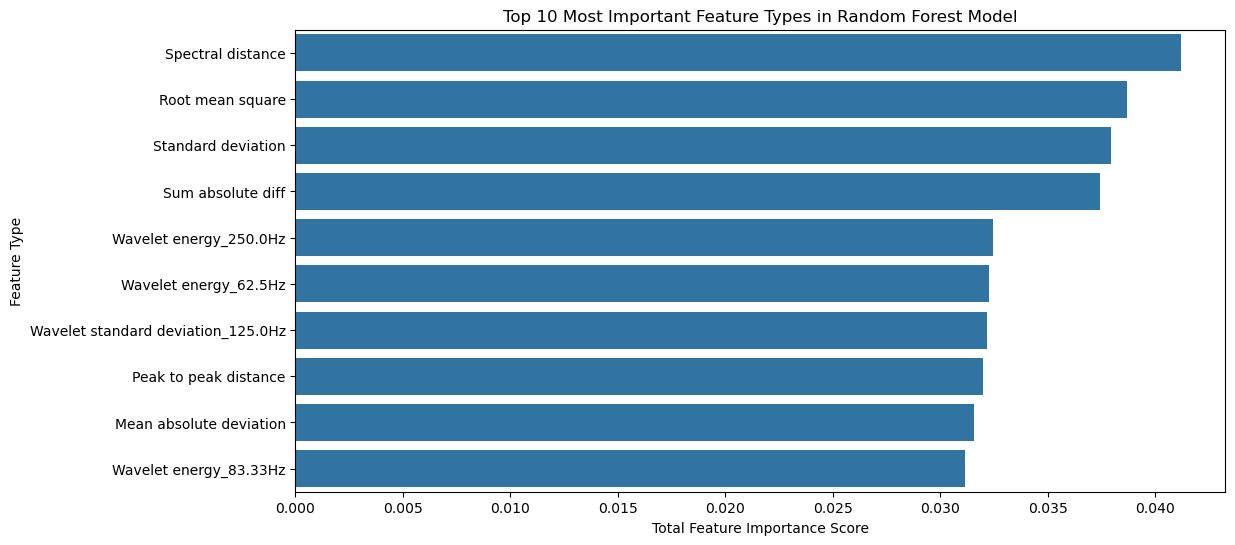

In [27]:
# Plot the top 20 most important general features
plt.figure(figsize=(12, 6))
sns.barplot(x=general_importance_df.Importance[:10], y=general_importance_df["General Feature"][:10])
plt.xlabel("Total Feature Importance Score")
plt.ylabel("Feature Type")
plt.title("Top 10 Most Important Feature Types in Random Forest Model")
plt.show()

In [29]:
# Select only the top 10 features
top_features = general_importance_df["General Feature"][:10].tolist()

# Filter X_df to only include the top features (for all channels)
selected_columns = [col for col in X_df.columns if any(feature in col for feature in top_features)]
X_top10 = X_df[selected_columns]

# Print new feature shape
print(f"Reduced Feature Set Shape: {X_top10.shape}")

Reduced Feature Set Shape: (11105, 80)


In [30]:
# Train-test split
X_train_top10, X_test_top10, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest on reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_reduced.fit(X_train_top10, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
# Predict on training set
y_train_pred = rf_reduced.predict(X_train_top10)

# Compute training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on testing set
y_test_pred = rf_reduced.predict(X_test_top10)

# Compute testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy with Top 10 Features: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy with Top 10 Features: 1.0000
Testing Accuracy: 0.9919


Testing different tree counts on the top 10 feature model...

Trees: 500 | Train Acc: 1.0000 | Test Acc: 0.9941 | Train Time: 2.40s | Inference Time: 0.2649s
Trees: 300 | Train Acc: 1.0000 | Test Acc: 0.9928 | Train Time: 1.40s | Inference Time: 0.1408s
Trees: 200 | Train Acc: 1.0000 | Test Acc: 0.9932 | Train Time: 0.94s | Inference Time: 0.1097s
Trees: 100 | Train Acc: 1.0000 | Test Acc: 0.9919 | Train Time: 0.50s | Inference Time: 0.0615s
Trees: 50 | Train Acc: 1.0000 | Test Acc: 0.9923 | Train Time: 0.28s | Inference Time: 0.0456s
Trees: 25 | Train Acc: 0.9998 | Test Acc: 0.9914 | Train Time: 0.16s | Inference Time: 0.0308s
Trees: 10 | Train Acc: 0.9994 | Test Acc: 0.9860 | Train Time: 0.09s | Inference Time: 0.0312s
Trees: 5 | Train Acc: 0.9980 | Test Acc: 0.9757 | Train Time: 0.08s | Inference Time: 0.0305s
Trees: 1 | Train Acc: 0.9734 | Test Acc: 0.9239 | Train Time: 0.06s | Inference Time: 0.0040s


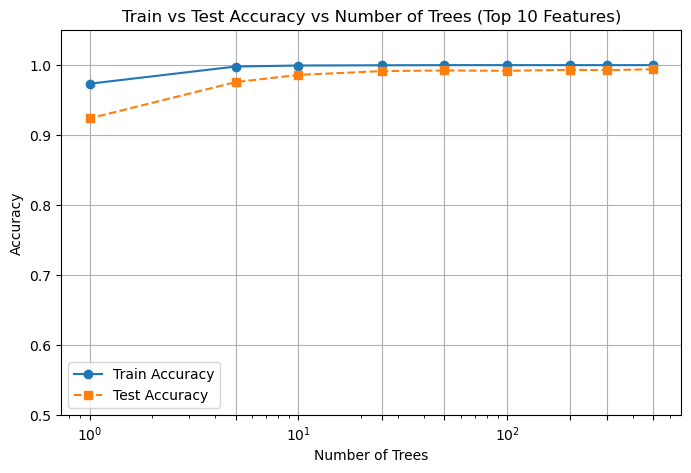

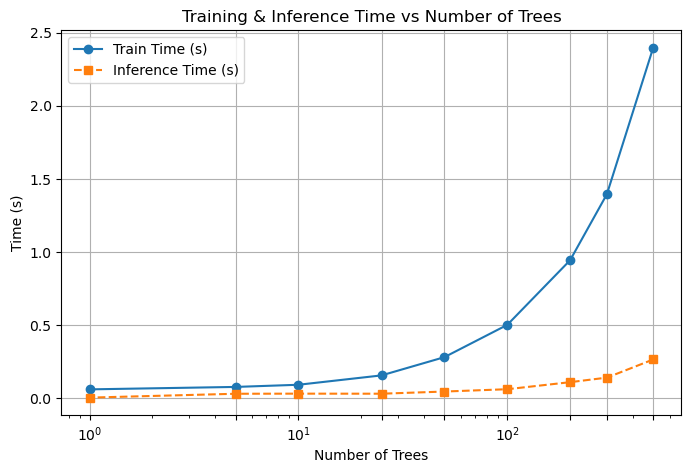

In [37]:
import time
# Define the different tree counts to test
tree_counts = [500, 300, 200, 100, 50, 25, 10, 5, 1]
results = []

print("Testing different tree counts on the top 10 feature model...\n")

for n_trees in tree_counts:
    # Measure training time
    start_time = time.time()
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train_top10, y_train)  # Use feature-selected dataset
    train_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    y_train_pred = rf_classifier.predict(X_train_top10)  # Training set prediction
    y_test_pred = rf_classifier.predict(X_test_top10)  # Testing set prediction
    inference_time = time.time() - start_time

    # Compute accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append((n_trees, train_accuracy, test_accuracy, train_time, inference_time))
    print(f"Trees: {n_trees} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f} | Train Time: {train_time:.2f}s | Inference Time: {inference_time:.4f}s")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Trees", "Train Accuracy", "Test Accuracy", "Train Time (s)", "Inference Time (s)"])

# Plot accuracy vs number of trees
plt.figure(figsize=(8, 5))
plt.plot(results_df["Trees"], results_df["Train Accuracy"], marker='o', linestyle='-', label="Train Accuracy")
plt.plot(results_df["Trees"], results_df["Test Accuracy"], marker='s', linestyle='--', label="Test Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy vs Number of Trees (Top 10 Features)")
plt.xscale("log")  # Log scale for better visualization
plt.xticks(results_df["Trees"])  # Show specific tree counts on x-axis
plt.ylim(0.5, 1.05)  # Keep y-axis in a reasonable range
plt.legend()
plt.grid(True)
plt.show()

# Plot training time and inference time vs number of trees
plt.figure(figsize=(8, 5))
plt.plot(results_df["Trees"], results_df["Train Time (s)"], marker='o', linestyle='-', label="Train Time (s)")
plt.plot(results_df["Trees"], results_df["Inference Time (s)"], marker='s', linestyle='--', label="Inference Time (s)")
plt.xlabel("Number of Trees")
plt.ylabel("Time (s)")
plt.title("Training & Inference Time vs Number of Trees")
plt.xscale("log")  # Log scale for better visualization
plt.xticks(results_df["Trees"])  # Show specific tree counts on x-axis
plt.legend()
plt.grid(True)
plt.show()
